In [27]:
%pip install numpy pandas matplotlib scikit-learn scikit-image seaborn plotly timm albumentations torch torchvision torchaudio colorama segmentation-models-pytorch

In [28]:
import numpy as np
import pandas as pd
# pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os
from tqdm import tqdm
tqdm.pandas()

from dataclasses import dataclass


# visualization
import cv2
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
from torch.cuda.amp import autocast, GradScaler
from torch.optim import Optimizer

# Albumentations for augmentations
import albumentations as A
from albumentations.augmentations.crops.transforms import RandomCrop
from albumentations.pytorch import ToTensorV2


# Add Monitoring and Logging
import wandb
from datetime import datetime

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from google.colab import userdata
WANDB_API_KEY = userdata.get('WANDB_API_KEY')
if not WANDB_API_KEY:
    raise ValueError("WANDB_API_KEY environment variable is not set.")

# ⚙️ Configuration

In [29]:


@dataclass
class CFG:
    seed          = 2025
    backbone      = "efficientnet-b3"# "efficientnet-b3" # se_resnext101_32x4d - se_resnext50_32x4d - efficientnet-b3  timm-resnest101e
    decoder_attention_type = "scse"
    train_bs      = 3
    valid_bs      = train_bs*2
    img_size      = [1536, 786]
    crop_size     = [512, 512]
    epochs        = 150 # 40
    lr            = 1e-4
    max_grad_norm = 100
    scheduler     = "ReduceLROnPlateau" #'OneCycle' # ReduceLROnPlateau CosineAnnealingLR CustomCosineAnnealingWarmupRestarts
    min_lr        = 5e-5
    T_max         = int(17000/train_bs*epochs)+50
    T_0           = 25
    max_lr        = 4e-4
    warmup_epochs = 0
    wd            = 5e-6
    n_accumulate  = 1
    n_fold        = 4
    folds         = [0, 1, 2, 3]
    num_classes   = 1
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    aux_head      = False
    thresh        = [0.3, 0.4, 0.5, 0.6, 0.7]


In [30]:
# Initialize W&B run
wandb.login(key=WANDB_API_KEY)
run = wandb.init(
    project="tumor-segmentation",
    entity="nm-i-ki",
    name=f"train_unet_kfold_tta_{datetime.now():%Y%m%d_%H%M%S}",
    config={
        "seed": CFG.seed,
        "backbone": CFG.backbone,
        "decoder_attention_type": CFG.decoder_attention_type,
        "train_bs": CFG.train_bs,
        "valid_bs": CFG.valid_bs,
        "img_size": CFG.img_size,
        "crop_size": CFG.crop_size,
        "epochs": CFG.epochs,
        "lr": CFG.lr,
        "max_grad_norm": CFG.max_grad_norm,
        "scheduler": CFG.scheduler,
        "min_lr": CFG.min_lr,
        "T_max": CFG.T_max,
        "T_0": CFG.T_0,
        "max_lr": CFG.max_lr,
        "warmup_epochs": CFG.warmup_epochs,
        "wd": CFG.wd,
        "n_accumulate": CFG.n_accumulate,
        "n_fold": CFG.n_fold,
        "folds": CFG.folds,
        "num_classes": CFG.num_classes,
        "aux_head": CFG.aux_head,
        "thresh": CFG.thresh,
    },
    tags=["segmentation", "efficientnet"],
    save_code=True,
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
train_loss,▆▆▇▁█▆▆▂▅▄▄▄▂▄▂▃▁▂▂▃▂▁▃▂▃▂▂▂▁▂▃▃▂▂▂▁▂▂▁▃
val_dice,█▇▅▅▆▄▅▇▄█▄▆▇▄▄▅▃▅▄▄▃▅▄▆▅▁▁▆▃▃▃▅▇▅▃▃▅▃▄▁
val_loss,▁▆▆▆▆▆▅▆▅▇▆▆▅▆▆▆▅▆▆▇▇▆▇▅▇▇██▆▇▅▇▅▆▇▇▆▇▇█
epoch,58
train_loss,26.87852
val_dice,0.01487
val_loss,0.98503


# ❗ Reproducibility

In [31]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('-> SEEDING DONE')

set_seed(CFG.seed)

-> SEEDING DONE


In [32]:
from google.colab import drive
drive.mount('/content/drive')
# CONTROLS_DIR = "/content/drive/MyDrive/data/raw/tumor-segmentation/controls/"
PATIENTS_DIR = "/content/drive/MyDrive/data/raw/tumor-segmentation/patients"

rows = []
data_df = pd.DataFrame(columns=['image_id', 'image_path', 'label_path', 'label'])

# Load the control images
# control_images = glob(os.path.join(CONTROLS_DIR, "imgs", "*.png"))
# for img_path in control_images:
#     image_id = os.path.basename(img_path).split('/')[-1]
#     rows.append({'image_id': image_id, 'image_path': f'{CONTROLS_DIR}/imgs/{image_id}', 'label_path': '', 'label': 0})

# Load the patient images
patient_images = glob(os.path.join(PATIENTS_DIR, "imgs", "*.png"))
segmentation_labels = glob(os.path.join(PATIENTS_DIR, "labels", "*.png"))
for img_path, label_path in zip(patient_images, segmentation_labels):
    image_id = os.path.basename(img_path).split('/')[-1]
    label_id = image_id.replace('patient', 'segmentation')
    rows.append({'image_id': image_id, 'image_path': f'{PATIENTS_DIR}/imgs/{image_id}', 'label_path': f'{PATIENTS_DIR}/labels/{label_id}', 'label': 1})

data_df = pd.DataFrame(rows)
data_df = data_df.reset_index(drop=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Class Distribution

In [33]:
df = data_df.copy()
df['label'].value_counts()

,count
label,
1,182


# 🔨 Utility

In [34]:
def load_img(image_path, mask_path, scale = True):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (CFG.img_size[1], CFG.img_size[0]), interpolation=cv2.INTER_LINEAR)
    if mask_path == "":
        mask = np.zeros_like(img, dtype=np.uint8)
    else:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (CFG.img_size[1], CFG.img_size[0]), interpolation=cv2.INTER_LINEAR)
        mask = (mask > 0).astype(np.uint8)

    img = np.expand_dims(img.astype("float32"), axis=-1)
    mask = np.expand_dims(mask.astype("float32"), axis=-1)
    if scale:
        img = (img - img.min()) / (img.max() - img.min())
        # img = (img - img.mean()) / img.std()
    assert img.shape == mask.shape, f"Image shape {img.shape} does not match mask shape {mask.shape}"
    return img, mask


def get_dice(preds, masks, threshold=0.5, epsilon=1e-6):
    """
    Compute per-image Dice coefficient and return the mean across the batch.

    preds, masks: np.ndarray of shape (B, H, W) or (B, 1, H, W)
    """
    preds = (preds > threshold).astype(np.uint8)
    masks = (masks > threshold).astype(np.uint8)

    if preds.ndim == 4 and preds.shape[1] == 1:
        preds = preds[:, 0]
        masks = masks[:, 0]

    intersection = (preds & masks).sum(axis=(1, 2))
    total = preds.sum(axis=(1, 2)) + masks.sum(axis=(1, 2))

    dice_scores = (2.0 * intersection + epsilon) / (total + epsilon)
    return dice_scores.mean()



# 📁 Create Folds

In [35]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold,(train_idx, val_idx) in enumerate(skf.split(df, df['label'], df['image_id'])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','label'])['image_id'].count())

,,image_id
fold,label,
0.0,1,46
1.0,1,46
2.0,1,45
3.0,1,45


# 🍚 Dataset

In [36]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self,
                 df,
                 transforms=None):

        self.df           = df.reset_index(drop=True)
        self.transforms   = transforms
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.df.image_path[index]
        label_path = self.df.label_path[index]

        ## Load the image (RGB)
        img, mask = load_img(img_path, label_path, True)
        ## Apply Augmentations:
        if self.transforms:
            data = self.transforms(image=img, mask=mask)
            img  = data['image']
            mask = data['mask']
            img = np.transpose(img, (2, 0, 1))
        else:
            img = np.transpose(img, (2, 0, 1))

        mask = np.transpose(mask, (2, 0, 1))

        # if CFG.aux_head and self.label:
        #     labels = np.where(mask.sum((1, 2)) > 0, 1, 0)
        # else:
        #     labels = mask
        img = torch.tensor(img)
        mask = torch.tensor(mask)
        return torch.tensor(img), torch.tensor(mask), img_path


class TTADataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, tta_transforms):
        self.base_dataset = base_dataset
        self.tta_transforms = tta_transforms

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, mask, img_path = self.base_dataset[idx]

        image = image.permute(1, 2, 0).numpy()

        all_aug_images = []
        for t in self.tta_transforms:
            aug = t(image=image)['image']
            aug = torch.from_numpy(aug).permute(2, 0, 1).float()  # back to CHW
            all_aug_images.append(aug)

        return torch.stack(all_aug_images), mask, img_path

# Augmentations

In [37]:
data_transforms = {"train": A.Compose([A.HorizontalFlip(p=0.5),
                                       A.VerticalFlip(p=0.5),
                                       A.RandomBrightnessContrast(brightness_limit=[-0.4, 0.4],contrast_limit=[0,0],p=0.5),
                                       A.GaussianBlur(sigma_limit=[0.2, 0.7],p=0.5),
                                       A.GaussNoise(std_range=[0.01,0.15],per_channel=False,noise_scale_factor=1.0,p=0.5),
                                       A.SaltAndPepper(p=0.05),
                                    #    A.ShiftScaleRotate(rotate_limit=25, scale_limit=0.15, shift_limit=0, p=0.25),
#                                        A.CoarseDropout(max_holes=16, max_height=64 ,max_width=64 ,p=0.5),
#                                        A.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.25, p=0.75),
#                                        A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, p=0.5),
                                       # A.RandomCrop(height=CFG.img_size[0], width=CFG.img_size[1], always_apply=True, p=1),
                                       # A.Normalize(p=1)
                                        ]),

                    "valid": A.Compose([]),#PadToDivisible(divisible=32, always_apply=True, p=1.0),

                    "tta": [
                        A.Compose([]),  # identity
                        A.HorizontalFlip(p=1.0),
                        A.VerticalFlip(p=1.0)
                     ]
                    }

# DataLoader

In [38]:
def prepare_loaders(fold, non_empty=False):
    train_df = df[df.fold != fold].reset_index(drop=True)
    valid_df = df[df.fold == fold].reset_index(drop=True)

    if non_empty:
        train_df = train_df[train_df['label'] == 0].reset_index(drop=True)
        valid_df = valid_df[valid_df['label'] == 0].reset_index(drop=True)

    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])

    # Wrap the validation dataset in a deterministic TTA wrapper
    base_oof_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])
    oof_dataset = TTADataset(base_oof_dataset, tta_transforms=data_transforms['tta'])

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs,
                              num_workers=8, shuffle=True, pin_memory=True, drop_last=False)

    valid_loader = DataLoader(valid_dataset, batch_size=1,
                              num_workers=8, shuffle=False, pin_memory=True)

    oof_loader = DataLoader(oof_dataset, batch_size=1,  # returns [1, T, C, H, W]
                            num_workers=8, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, oof_loader, len(train_df) // CFG.train_bs, valid_df

In [39]:
train_loader, valid_loader, oof_loader, training_steps, valid_df = prepare_loaders(fold=0)

In [40]:
imgs, masks, path_ = next(iter(train_loader))

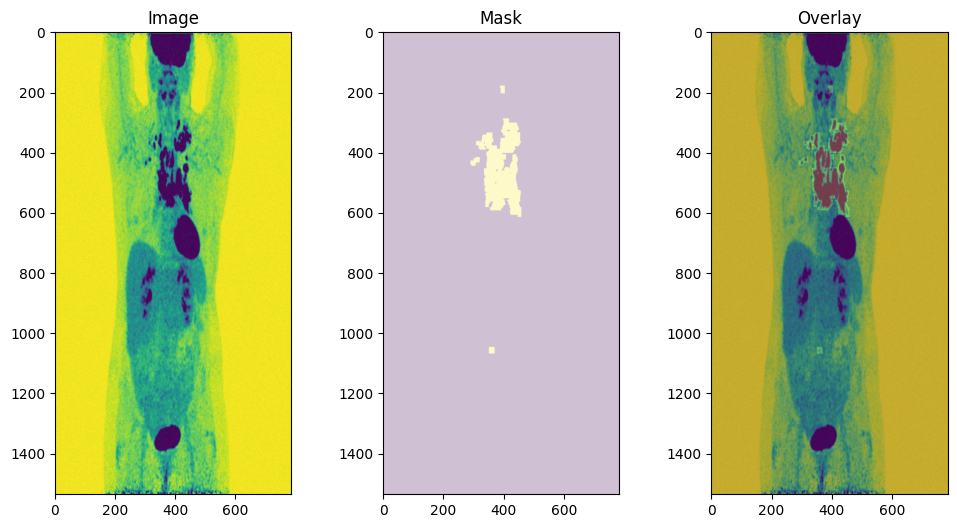

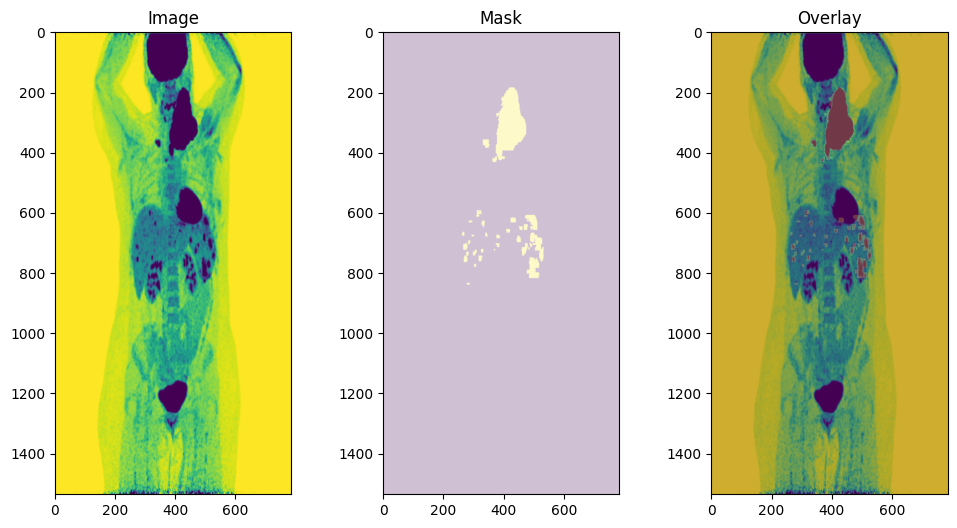

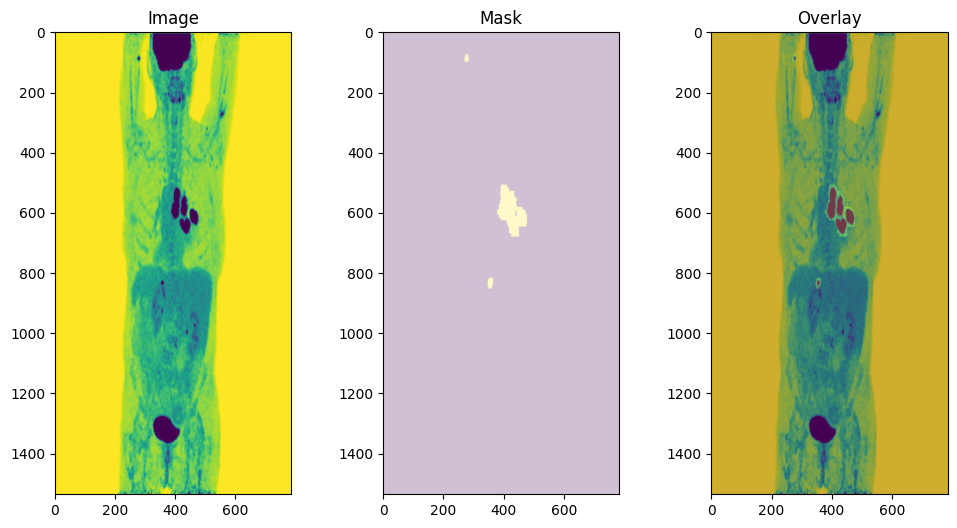

In [41]:
for i in range(imgs.shape[0]):
    #make the image and mask two suplots horizontally with third image overlaying them together
    _img = np.transpose(imgs[i].cpu().numpy(), (1, 2, 0))
    mask = np.transpose(masks[i].cpu().numpy(), (1, 2, 0))
    fig, ax = plt.subplots(1,3, figsize=(12, 6))
    ax[0].imshow(_img)
    ax[0].set_title("Image")
    ax[1].imshow(mask, alpha = 0.25)
    ax[1].set_title("Mask")
    ax[2].imshow(_img)
    ax[2].imshow(mask, alpha = 0.25)
    ax[2].set_title("Overlay")
    plt.show()

In [42]:
imgs, msks, paths_ = next(iter(valid_loader))

1.0 0.0
[0. 1.]


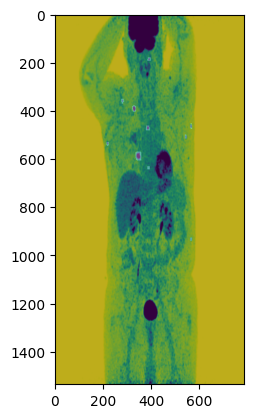

In [43]:
for i in range(imgs.shape[0]):
    _img = np.transpose(imgs[i].cpu().numpy(), (1, 2, 0))
    _mask = np.transpose(msks[i].cpu().numpy(), (1, 2, 0))
    print(_img.max(), _img.min())
    print(np.unique(_mask))
    plt.imshow(_img)
    plt.imshow(_mask, alpha = 0.25, cmap = 'gray')
    plt.show()

In [44]:
import gc
gc.collect()

29980

# 📦 Model

In [45]:


def build_model():
    model = smp.Unet(encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
                     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                     classes=1,                      # model output channels (number of classes in your dataset)
                     activation=None,
                     decoder_attention_type = CFG.decoder_attention_type, #"scse",
                     aux_params = None if not CFG.aux_head else {"classes": 1,
                                                                 "activation": None})
    model.to(CFG.device)
    return model


def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# 🔧 Loss Function

In [46]:
JaccardLoss    = smp.losses.JaccardLoss(mode='binary')
DiceLoss       = smp.losses.DiceLoss(mode='binary')
BCELoss        = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss     = smp.losses.LovaszLoss(mode='binary', per_image=False)
TverskyLoss    = smp.losses.TverskyLoss(mode='binary', log_loss=False, smooth=0.1)
SegFocalLoss   = smp.losses.FocalLoss(mode = 'binary')
BCE = torch.nn.BCEWithLogitsLoss()

def dice_coef(y_true, y_pred, thr=0.5, dim=(2, 3), epsilon=1e-6):
    y_true = y_true.float()
    y_pred = (y_pred > thr).float()
    inter = (y_true * y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = (2 * inter + epsilon) / (den + epsilon)
    return dice.mean()  # mean over batch (and channel if present)


def iou_coef(y_true, y_pred, thr=0.5, dim=(2, 3), epsilon=1e-6):
    y_true = y_true.float()
    y_pred = (y_pred > thr).float()
    inter = (y_true * y_pred).sum(dim=dim)
    union = y_true.sum(dim=dim) + y_pred.sum(dim=dim) - inter
    iou = (inter + epsilon) / (union + epsilon)
    return iou.mean()  # mean over batch


def criterion(y_pred, y_true):
    return DiceLoss(y_pred, y_true)

# def criterion(y_pred, y_true):
#     if CFG.aux_head:
#         y_true, yt_class = y_true
#         y_pred, yp_class = y_pred
#         return (0.5*DiceLoss(y_pred, y_true) + 0.5 * BCE(yp_class, yt_class))
#     return 0.5*DiceLoss(y_pred, y_true) + 0.5*SegFocalLoss(y_pred, y_true)

# 🚄 Training Function

In [47]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch:int):
    model.train()

    dataset_size = 0
    running_loss = 0.0
    train_jaccards = []
    train_dices = []

    sigmoid = torch.sigmoid  # Faster than instantiating nn.Sigmoid()

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')

    optimizer.zero_grad()

    for step, (images, masks, paths) in pbar:
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        batch_size = images.size(0)

        y_pred = model(images)
        loss = criterion(y_pred, masks)
        loss.backward()

        y_pred = sigmoid(y_pred)

        train_dice = dice_coef(masks, y_pred).cpu().item()
        train_jaccard = iou_coef(masks, y_pred).cpu().item()
        train_dices.append(train_dice)
        train_jaccards.append(train_jaccard)

        if (step + 1) % CFG.n_accumulate == 0:
            optimizer.step()
            optimizer.zero_grad()

            if scheduler and CFG.scheduler not in ["ReduceLROnPlateau", "ExponentialLR"]:
                scheduler.step()

        running_loss += loss.item() * batch_size
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        wandb.log({'train_loss': running_loss, 'epoch': epoch})
        # W&B per-epoch training metrics
        current_lr = optimizer.param_groups[0]['lr']
        mem = torch.cuda.memory_reserved() / 1e9 if torch.cuda.is_available() else 0

        pbar.set_postfix(loss=f'{epoch_loss:0.4f}',
                         lr=f'{current_lr:0.5f}',
                         jac=np.mean(train_jaccards),
                         dice=np.mean(train_dices),
                         gpu_mem=f'{mem:0.2f} GB')

    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, np.mean(train_dices), np.mean(train_jaccards)


# 👀 Validation Function

In [48]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, optimizer, epoch:int):
    model.eval()

    dataset_size = 0
    running_loss = 0.0
    global_masks = []
    global_preds = []

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')

    for step, (images, masks, paths) in pbar:
        images = images.float().to(device)
        masks = masks.float().to(device)
        batch_size = images.size(0)

        y_pred = model(images)
        loss = criterion(y_pred, masks)
        running_loss += loss.item() * batch_size
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        y_pred = torch.sigmoid(y_pred)
        global_masks.append(masks.cpu().numpy())
        global_preds.append(y_pred.detach().cpu().numpy())

        current_lr = optimizer.param_groups[0]['lr']
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                         lr=f'{current_lr:0.5f}',
                         gpu_mem=f'{mem:0.2f} GB')

    # For sample images, take first example of last batch
    # Concatenate all batches
    global_masks = np.concatenate(global_masks, axis=0)
    global_preds = np.concatenate(global_preds, axis=0)
    global_dice = get_dice(global_preds, global_masks)

    # Log overall validation metrics
    wandb.log({'val_loss': epoch_loss, 'val_dice': global_dice, 'epoch': epoch})

    # For sample images, take first example of last batch
    img_np = images[0].cpu().permute(1,2,0).numpy()
    mask_np = masks[0].cpu().permute(1,2,0).numpy()
    pred_np = global_preds[-1][0].astype('float32') # Remove transpose as it's a single channel
    wandb.log({
        'input': wandb.Image(img_np, caption='input'),
        'mask': wandb.Image(mask_np, caption='mask'),
        'pred': wandb.Image(pred_np, caption='pred'),
        'epoch': epoch
    })

    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, global_dice

In [49]:
def reverse_transform(pred, transform_type):
    if transform_type == "hflip":
        return np.fliplr(pred)
    elif transform_type == "vflip":
        return np.flipud(pred)
    elif transform_type == "identity":
        return pred
    else:
        raise ValueError(f"Unknown TTA transform: {transform_type}")

@torch.no_grad()
def oof_one_epoch(model, dataloader, device, valid_df, fold, tta_transform_names):
    model.eval()

    oof_scores = []
    global_preds = []
    global_masks = []

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='OOF Eval')

    for step, (tta_images, masks, img_path) in pbar:
        tta_images = tta_images.squeeze(0).to(device).float()
        masks = masks.squeeze(0).to(device).float()
        img_path = img_path[0] if isinstance(img_path, list) else img_path
        img_path = str(img_path)  # ensure string for merging

        preds = model(tta_images)
        preds = torch.sigmoid(preds).squeeze(1).cpu().numpy()
        masks_np = masks.squeeze().cpu().numpy()

        aligned_preds = []
        for pred, tname in zip(preds, tta_transform_names):
            aligned_preds.append(reverse_transform(pred, tname))

        aligned_preds = np.stack(aligned_preds, axis=0)
        tta_avg_pred = aligned_preds.mean(axis=0)
        base_pred = aligned_preds[0]

        base_dice = get_dice(base_pred[None], masks_np[None])
        tta_dice = get_dice(tta_avg_pred[None], masks_np[None])

        global_preds.append(tta_avg_pred[None])
        global_masks.append(masks_np[None])

        oof_scores.append({
            'image_path': img_path,
            'base_dice': base_dice,
            'tta_dice': tta_dice
        })

        pbar.set_postfix(base_dice=f'{base_dice:.4f}', tta_dice=f'{tta_dice:.4f}')

    df_scores = pd.DataFrame(oof_scores)

    # Merge on image_path instead of index
    valid_df = valid_df.copy()
    valid_df = valid_df.merge(df_scores, on='image_path', how='left')
    valid_df.to_csv(f'tta_results_fold_{fold}.csv', index=False)

    global_preds = np.concatenate(global_preds, axis=0)
    global_masks = np.concatenate(global_masks, axis=0)
    global_dice = get_dice(global_preds, global_masks)

    torch.cuda.empty_cache()
    gc.collect()

    return global_dice, valid_df

# 🏃 Run Training

In [50]:
from collections import defaultdict
import time
import copy
import torch
import gc
import numpy as np
import os

def run_training(model, optimizer, scheduler, num_epochs, train_loader, valid_loader, fold=0):
    if torch.cuda.is_available():
        print(f"CUDA: {torch.cuda.get_device_name()}\n")

    # Create the 'models' directory if it doesn't exist
    os.makedirs('models', exist_ok=True)

    wandb.watch(model, log='all', log_freq=10)

    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice = -np.inf
    best_epoch = -1
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        print(f"{'='*30}\nEpoch {epoch}/{num_epochs}")

        train_loss, train_dice, train_jaccard = train_one_epoch(
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            dataloader=train_loader,
            device=CFG.device,
            epoch=epoch,
        )

        val_loss, val_dice = valid_one_epoch(
            model=model,
            dataloader=valid_loader,
            device=CFG.device,
            optimizer=optimizer,
            epoch=epoch
        )

        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)

        print(f"Train Loss: {train_loss:.4f} - Train Dice: {train_dice:.4f} - Train Jaccard: {train_jaccard:.4f} | Valid Loss: {val_loss:.4f} | Valid Dice: {val_dice:.4f}")

        # Save best model
        if val_dice > best_dice:
            print(f"✓ Dice Improved: {best_dice:.4f} → {val_dice:.4f}")
            best_dice = val_dice
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())

            best_path = f'models/best_fold{fold}_dice{best_dice:.4f}.pth'
            torch.save(model.state_dict(), best_path)
            print(f"✔ Model saved to {best_path}")
            # W&B artifact
            artifact = wandb.Artifact(f'best_model_fold{fold}', type='model')
            artifact.add_file(best_path)
            run.log_artifact(artifact)

        # Always save last epoch
        last_path = f"last_epoch-S1-{fold:02d}.bin"
        torch.save(model.state_dict(), last_path)

        # Step scheduler if applicable
        if CFG.scheduler in ["ReduceLROnPlateau", "ExponentialLR"]:
            if CFG.scheduler == "ExponentialLR":
                scheduler.step()
            elif CFG.scheduler == "ReduceLROnPlateau":
                scheduler.step(val_loss)

        print()

    elapsed = time.time() - start_time
    h, m, s = int(elapsed // 3600), int((elapsed % 3600) // 60), int(elapsed % 60)
    print(f"🏁 Training complete in {h}h {m}m {s}s")
    print(f"🏆 Best Dice: {best_dice:.4f} (Epoch {best_epoch})")

    model.load_state_dict(best_model_wts)
    return model, history

In [51]:

def fetch_scheduler(optimizer: Optimizer, training_steps: int = 0):
    match CFG.scheduler:
        case "CosineAnnealingLR":
            scheduler = lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=training_steps * CFG.epochs, eta_min=CFG.min_lr
            )
        case "CosineAnnealingWarmRestarts":
            scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=training_steps * 8, T_mult=1, eta_min=CFG.min_lr
            )
        case "ReduceLROnPlateau":
            scheduler = lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="max",
                factor=0.5,
                patience=1,
                cooldown=1,
                min_lr=5e-6,
                threshold=0.00001,
            )
        case "OneCycle":
            scheduler = lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=CFG.max_lr,
                total_steps=training_steps * CFG.epochs,
                # epochs=CFG.epochs,
                # steps_per_epoch=training_steps,
                pct_start=0.25,
            )
        case "ExponentialLR":
            scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        case _:
            print(
                f"{c_}⚠️ WARNING: Unknown scheduler {CFG.scheduler}. Using StepLR with step_size=1.{sr_}"
            )
            return None

    return scheduler

# 🚅 Training

In [52]:
oof_dice_scores = []
all_oof_dfs = []
tta_transform_names = ["identity", "hflip", "vflip"]

for fold in CFG.folds:
    if fold != 2:
        print(f"{c_}Skipping fold {fold} for now.{sr_}")
        continue
    print(f'\n{"#"*30}\n##### Fold {fold}\n{"#"*30}\n')
    run.name = f"fold{fold}_{datetime.now():%Y%m%d_%H%M%S}"
    model = build_model()

    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=0.05)
    CFG.scheduler = "CosineAnnealingLR"

    # Loaders for this fold (train + valid + TTA OOF)
    train_loader, valid_loader, oof_loader, train_steps, valid_df = prepare_loaders(
        fold=fold,
        non_empty=False,
    )

    scheduler = fetch_scheduler(optimizer, train_steps)

    # Train model
    model, _ = run_training(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=CFG.epochs,
        train_loader=train_loader,
        valid_loader=valid_loader,
        fold=fold
    )

    # TTA-based OOF prediction
    oof_dice, valid_df_with_scores = oof_one_epoch(
        model=model,
        dataloader=oof_loader,
        device=CFG.device,
        valid_df=valid_df,
        fold=fold,
        tta_transform_names=tta_transform_names
    )

    print(f"✅ Fold {fold} OOF Dice: {oof_dice:.4f}")

    oof_dice_scores.append(oof_dice)
    all_oof_dfs.append(valid_df_with_scores)

# Final average OOF Dice
mean_oof_dice = np.mean(oof_dice_scores)
print(f"\n{'='*40}\n🏁 Final OOF Dice across all folds: {mean_oof_dice:.4f}")

# Save full OOF dataframe
final_oof_df = pd.concat(all_oof_dfs, ignore_index=True)
final_oof_df.to_csv("oof_scores_all_folds.csv", index=False)

# Finish W&B
run.finish()


Skipping fold 0 for now.
Skipping fold 1 for now.

##############################
##### Fold 2
##############################

CUDA: NVIDIA A100-SXM4-40GB

Epoch 1/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.22it/s, gpu_mem=1.64 GB, lr=0.00010, valid_loss=0.9666]


Train Loss: 0.9640 - Train Dice: 0.0964 - Train Jaccard: 0.0542 | Valid Loss: 0.9666 | Valid Dice: 0.0441
✓ Dice Improved: -inf → 0.0441
✔ Model saved to models/best_fold2_dice0.0441.pth

Epoch 2/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.17it/s, gpu_mem=1.66 GB, lr=0.00010, valid_loss=0.9239]


Train Loss: 0.9389 - Train Dice: 0.1550 - Train Jaccard: 0.0918 | Valid Loss: 0.9239 | Valid Dice: 0.5026
✓ Dice Improved: 0.0441 → 0.5026
✔ Model saved to models/best_fold2_dice0.5026.pth

Epoch 3/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.25it/s, gpu_mem=1.67 GB, lr=0.00010, valid_loss=0.8835]


Train Loss: 0.9046 - Train Dice: 0.2283 - Train Jaccard: 0.1404 | Valid Loss: 0.8835 | Valid Dice: 0.5805
✓ Dice Improved: 0.5026 → 0.5805
✔ Model saved to models/best_fold2_dice0.5805.pth

Epoch 4/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.46it/s, gpu_mem=1.63 GB, lr=0.00010, valid_loss=0.7894]


Train Loss: 0.8521 - Train Dice: 0.3759 - Train Jaccard: 0.2544 | Valid Loss: 0.7894 | Valid Dice: 0.6242
✓ Dice Improved: 0.5805 → 0.6242
✔ Model saved to models/best_fold2_dice0.6242.pth

Epoch 5/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.19it/s, gpu_mem=1.64 GB, lr=0.00010, valid_loss=0.7603]


Train Loss: 0.7721 - Train Dice: 0.4803 - Train Jaccard: 0.3486 | Valid Loss: 0.7603 | Valid Dice: 0.5960

Epoch 6/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.25it/s, gpu_mem=1.64 GB, lr=0.00010, valid_loss=0.6119]


Train Loss: 0.6678 - Train Dice: 0.5806 - Train Jaccard: 0.4442 | Valid Loss: 0.6119 | Valid Dice: 0.6632
✓ Dice Improved: 0.6242 → 0.6632
✔ Model saved to models/best_fold2_dice0.6632.pth

Epoch 7/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.08it/s, gpu_mem=1.63 GB, lr=0.00010, valid_loss=0.5504]


Train Loss: 0.5931 - Train Dice: 0.5725 - Train Jaccard: 0.4364 | Valid Loss: 0.5504 | Valid Dice: 0.7011
✓ Dice Improved: 0.6632 → 0.7011
✔ Model saved to models/best_fold2_dice0.7011.pth

Epoch 8/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.96it/s, gpu_mem=1.64 GB, lr=0.00010, valid_loss=0.4794]


Train Loss: 0.5057 - Train Dice: 0.6377 - Train Jaccard: 0.4999 | Valid Loss: 0.4794 | Valid Dice: 0.6874

Epoch 9/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.27it/s, gpu_mem=1.64 GB, lr=0.00010, valid_loss=0.4304]


Train Loss: 0.4353 - Train Dice: 0.6746 - Train Jaccard: 0.5386 | Valid Loss: 0.4304 | Valid Dice: 0.6946

Epoch 10/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.40it/s, gpu_mem=1.64 GB, lr=0.00010, valid_loss=0.4170]


Train Loss: 0.4023 - Train Dice: 0.6610 - Train Jaccard: 0.5235 | Valid Loss: 0.4170 | Valid Dice: 0.7069
✓ Dice Improved: 0.7011 → 0.7069
✔ Model saved to models/best_fold2_dice0.7069.pth

Epoch 11/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.38it/s, gpu_mem=1.64 GB, lr=0.00010, valid_loss=0.3616]


Train Loss: 0.3621 - Train Dice: 0.6934 - Train Jaccard: 0.5629 | Valid Loss: 0.3616 | Valid Dice: 0.7253
✓ Dice Improved: 0.7069 → 0.7253
✔ Model saved to models/best_fold2_dice0.7253.pth

Epoch 12/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.34it/s, gpu_mem=1.65 GB, lr=0.00010, valid_loss=0.4311]


Train Loss: 0.3708 - Train Dice: 0.6597 - Train Jaccard: 0.5313 | Valid Loss: 0.4311 | Valid Dice: 0.6284

Epoch 13/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.31it/s, gpu_mem=1.65 GB, lr=0.00010, valid_loss=0.3176]


Train Loss: 0.3108 - Train Dice: 0.7055 - Train Jaccard: 0.5759 | Valid Loss: 0.3176 | Valid Dice: 0.7441
✓ Dice Improved: 0.7253 → 0.7441
✔ Model saved to models/best_fold2_dice0.7441.pth

Epoch 14/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.41it/s, gpu_mem=1.64 GB, lr=0.00010, valid_loss=0.3412]


Train Loss: 0.2934 - Train Dice: 0.7234 - Train Jaccard: 0.5937 | Valid Loss: 0.3412 | Valid Dice: 0.7168

Epoch 15/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  9.00it/s, gpu_mem=1.64 GB, lr=0.00010, valid_loss=0.3045]


Train Loss: 0.2482 - Train Dice: 0.7546 - Train Jaccard: 0.6280 | Valid Loss: 0.3045 | Valid Dice: 0.7409

Epoch 16/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.13it/s, gpu_mem=1.64 GB, lr=0.00010, valid_loss=0.3191]


Train Loss: 0.2499 - Train Dice: 0.7455 - Train Jaccard: 0.6219 | Valid Loss: 0.3191 | Valid Dice: 0.7240

Epoch 17/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.30it/s, gpu_mem=1.64 GB, lr=0.00010, valid_loss=0.3052]


Train Loss: 0.2762 - Train Dice: 0.7198 - Train Jaccard: 0.5882 | Valid Loss: 0.3052 | Valid Dice: 0.7307

Epoch 18/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.13it/s, gpu_mem=1.64 GB, lr=0.00010, valid_loss=0.2784]


Train Loss: 0.2590 - Train Dice: 0.7343 - Train Jaccard: 0.6071 | Valid Loss: 0.2784 | Valid Dice: 0.7503
✓ Dice Improved: 0.7441 → 0.7503
✔ Model saved to models/best_fold2_dice0.7503.pth

Epoch 19/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.98it/s, gpu_mem=1.65 GB, lr=0.00010, valid_loss=0.3311]


Train Loss: 0.2348 - Train Dice: 0.7523 - Train Jaccard: 0.6263 | Valid Loss: 0.3311 | Valid Dice: 0.6939

Epoch 20/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.32it/s, gpu_mem=1.65 GB, lr=0.00010, valid_loss=0.3782]


Train Loss: 0.2244 - Train Dice: 0.7543 - Train Jaccard: 0.6305 | Valid Loss: 0.3782 | Valid Dice: 0.6408

Epoch 21/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.39it/s, gpu_mem=1.65 GB, lr=0.00010, valid_loss=0.2895]


Train Loss: 0.2317 - Train Dice: 0.7673 - Train Jaccard: 0.6403 | Valid Loss: 0.2895 | Valid Dice: 0.7294

Epoch 22/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.44it/s, gpu_mem=1.65 GB, lr=0.00010, valid_loss=0.2928]


Train Loss: 0.2252 - Train Dice: 0.7589 - Train Jaccard: 0.6364 | Valid Loss: 0.2928 | Valid Dice: 0.7246

Epoch 23/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.49it/s, gpu_mem=1.65 GB, lr=0.00010, valid_loss=0.2606]


Train Loss: 0.2050 - Train Dice: 0.7816 - Train Jaccard: 0.6613 | Valid Loss: 0.2606 | Valid Dice: 0.7527
✓ Dice Improved: 0.7503 → 0.7527
✔ Model saved to models/best_fold2_dice0.7527.pth

Epoch 24/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.35it/s, gpu_mem=1.64 GB, lr=0.00010, valid_loss=0.2452]


Train Loss: 0.2018 - Train Dice: 0.7788 - Train Jaccard: 0.6589 | Valid Loss: 0.2452 | Valid Dice: 0.7672
✓ Dice Improved: 0.7527 → 0.7672
✔ Model saved to models/best_fold2_dice0.7672.pth

Epoch 25/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.09it/s, gpu_mem=1.65 GB, lr=0.00010, valid_loss=0.2760]


Train Loss: 0.2110 - Train Dice: 0.7723 - Train Jaccard: 0.6531 | Valid Loss: 0.2760 | Valid Dice: 0.7374

Epoch 26/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.09it/s, gpu_mem=1.65 GB, lr=0.00010, valid_loss=0.2773]


Train Loss: 0.2048 - Train Dice: 0.7918 - Train Jaccard: 0.6719 | Valid Loss: 0.2773 | Valid Dice: 0.7338

Epoch 27/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.27it/s, gpu_mem=1.65 GB, lr=0.00010, valid_loss=0.2755]


Train Loss: 0.1863 - Train Dice: 0.7885 - Train Jaccard: 0.6710 | Valid Loss: 0.2755 | Valid Dice: 0.7359

Epoch 28/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.07it/s, gpu_mem=1.65 GB, lr=0.00010, valid_loss=0.2646]


Train Loss: 0.1913 - Train Dice: 0.7856 - Train Jaccard: 0.6695 | Valid Loss: 0.2646 | Valid Dice: 0.7461

Epoch 29/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.15it/s, gpu_mem=1.65 GB, lr=0.00010, valid_loss=0.2902]


Train Loss: 0.2018 - Train Dice: 0.7726 - Train Jaccard: 0.6528 | Valid Loss: 0.2902 | Valid Dice: 0.7192

Epoch 30/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.28it/s, gpu_mem=1.65 GB, lr=0.00010, valid_loss=0.2594]


Train Loss: 0.2053 - Train Dice: 0.7920 - Train Jaccard: 0.6726 | Valid Loss: 0.2594 | Valid Dice: 0.7497

Epoch 31/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.37it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2860]


Train Loss: 0.1943 - Train Dice: 0.7987 - Train Jaccard: 0.6809 | Valid Loss: 0.2860 | Valid Dice: 0.7202

Epoch 32/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.40it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2403]


Train Loss: 0.1741 - Train Dice: 0.8014 - Train Jaccard: 0.6869 | Valid Loss: 0.2403 | Valid Dice: 0.7671

Epoch 33/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.53it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2431]


Train Loss: 0.1748 - Train Dice: 0.8049 - Train Jaccard: 0.6916 | Valid Loss: 0.2431 | Valid Dice: 0.7632

Epoch 34/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.62it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2717]


Train Loss: 0.1680 - Train Dice: 0.8084 - Train Jaccard: 0.6964 | Valid Loss: 0.2717 | Valid Dice: 0.7359

Epoch 35/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.17it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2735]


Train Loss: 0.1751 - Train Dice: 0.8071 - Train Jaccard: 0.6931 | Valid Loss: 0.2735 | Valid Dice: 0.7327

Epoch 36/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.09it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.3006]


Train Loss: 0.1805 - Train Dice: 0.8102 - Train Jaccard: 0.6951 | Valid Loss: 0.3006 | Valid Dice: 0.7055

Epoch 37/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.13it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2855]


Train Loss: 0.1884 - Train Dice: 0.7936 - Train Jaccard: 0.6760 | Valid Loss: 0.2855 | Valid Dice: 0.7207

Epoch 38/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.96it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2697]


Train Loss: 0.1637 - Train Dice: 0.8181 - Train Jaccard: 0.7065 | Valid Loss: 0.2697 | Valid Dice: 0.7359

Epoch 39/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.10it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2709]


Train Loss: 0.1706 - Train Dice: 0.8121 - Train Jaccard: 0.6983 | Valid Loss: 0.2709 | Valid Dice: 0.7346

Epoch 40/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.50it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2559]


Train Loss: 0.1615 - Train Dice: 0.8192 - Train Jaccard: 0.7075 | Valid Loss: 0.2559 | Valid Dice: 0.7500

Epoch 41/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.33it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2538]


Train Loss: 0.1556 - Train Dice: 0.8217 - Train Jaccard: 0.7139 | Valid Loss: 0.2538 | Valid Dice: 0.7512

Epoch 42/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.30it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2565]


Train Loss: 0.1578 - Train Dice: 0.8275 - Train Jaccard: 0.7191 | Valid Loss: 0.2565 | Valid Dice: 0.7480

Epoch 43/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.17it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.3078]


Train Loss: 0.1662 - Train Dice: 0.8247 - Train Jaccard: 0.7147 | Valid Loss: 0.3078 | Valid Dice: 0.6964

Epoch 44/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.34it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2788]


Train Loss: 0.1659 - Train Dice: 0.8125 - Train Jaccard: 0.7007 | Valid Loss: 0.2788 | Valid Dice: 0.7247

Epoch 45/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.22it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2374]


Train Loss: 0.1562 - Train Dice: 0.8215 - Train Jaccard: 0.7106 | Valid Loss: 0.2374 | Valid Dice: 0.7669

Epoch 46/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.04it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2434]


Train Loss: 0.1590 - Train Dice: 0.8247 - Train Jaccard: 0.7155 | Valid Loss: 0.2434 | Valid Dice: 0.7602

Epoch 47/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.16it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2331]


Train Loss: 0.1461 - Train Dice: 0.8359 - Train Jaccard: 0.7295 | Valid Loss: 0.2331 | Valid Dice: 0.7703
✓ Dice Improved: 0.7672 → 0.7703
✔ Model saved to models/best_fold2_dice0.7703.pth

Epoch 48/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.18it/s, gpu_mem=1.64 GB, lr=0.00009, valid_loss=0.2390]


Train Loss: 0.1537 - Train Dice: 0.8328 - Train Jaccard: 0.7260 | Valid Loss: 0.2390 | Valid Dice: 0.7639

Epoch 49/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.13it/s, gpu_mem=1.64 GB, lr=0.00009, valid_loss=0.3029]


Train Loss: 0.1515 - Train Dice: 0.8274 - Train Jaccard: 0.7219 | Valid Loss: 0.3029 | Valid Dice: 0.7008

Epoch 50/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.41it/s, gpu_mem=1.64 GB, lr=0.00009, valid_loss=0.2484]


Train Loss: 0.1474 - Train Dice: 0.8354 - Train Jaccard: 0.7281 | Valid Loss: 0.2484 | Valid Dice: 0.7547

Epoch 51/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.37it/s, gpu_mem=1.64 GB, lr=0.00009, valid_loss=0.2299]


Train Loss: 0.1479 - Train Dice: 0.8371 - Train Jaccard: 0.7314 | Valid Loss: 0.2299 | Valid Dice: 0.7734
✓ Dice Improved: 0.7703 → 0.7734
✔ Model saved to models/best_fold2_dice0.7734.pth

Epoch 52/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.40it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2312]


Train Loss: 0.1377 - Train Dice: 0.8412 - Train Jaccard: 0.7372 | Valid Loss: 0.2312 | Valid Dice: 0.7719

Epoch 53/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.50it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2352]


Train Loss: 0.1389 - Train Dice: 0.8441 - Train Jaccard: 0.7393 | Valid Loss: 0.2352 | Valid Dice: 0.7683

Epoch 54/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.24it/s, gpu_mem=1.65 GB, lr=0.00009, valid_loss=0.2483]


Train Loss: 0.1517 - Train Dice: 0.8155 - Train Jaccard: 0.7087 | Valid Loss: 0.2483 | Valid Dice: 0.7548

Epoch 55/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.15it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2371]


Train Loss: 0.1484 - Train Dice: 0.8288 - Train Jaccard: 0.7248 | Valid Loss: 0.2371 | Valid Dice: 0.7657

Epoch 56/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.16it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2461]


Train Loss: 0.1676 - Train Dice: 0.8159 - Train Jaccard: 0.7053 | Valid Loss: 0.2461 | Valid Dice: 0.7567

Epoch 57/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.07it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2393]


Train Loss: 0.1590 - Train Dice: 0.8355 - Train Jaccard: 0.7287 | Valid Loss: 0.2393 | Valid Dice: 0.7634

Epoch 58/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.03it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2518]


Train Loss: 0.1458 - Train Dice: 0.8332 - Train Jaccard: 0.7285 | Valid Loss: 0.2518 | Valid Dice: 0.7505

Epoch 59/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.30it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2570]


Train Loss: 0.1429 - Train Dice: 0.8389 - Train Jaccard: 0.7357 | Valid Loss: 0.2570 | Valid Dice: 0.7451

Epoch 60/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.46it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2543]


Train Loss: 0.1427 - Train Dice: 0.8418 - Train Jaccard: 0.7387 | Valid Loss: 0.2543 | Valid Dice: 0.7482

Epoch 61/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.46it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2449]


Train Loss: 0.1444 - Train Dice: 0.8442 - Train Jaccard: 0.7408 | Valid Loss: 0.2449 | Valid Dice: 0.7573

Epoch 62/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.48it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2465]


Train Loss: 0.1357 - Train Dice: 0.8506 - Train Jaccard: 0.7495 | Valid Loss: 0.2465 | Valid Dice: 0.7557

Epoch 63/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.45it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2317]


Train Loss: 0.1434 - Train Dice: 0.8452 - Train Jaccard: 0.7433 | Valid Loss: 0.2317 | Valid Dice: 0.7702

Epoch 64/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.35it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2423]


Train Loss: 0.1363 - Train Dice: 0.8532 - Train Jaccard: 0.7535 | Valid Loss: 0.2423 | Valid Dice: 0.7600

Epoch 65/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.21it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2537]


Train Loss: 0.1392 - Train Dice: 0.8439 - Train Jaccard: 0.7415 | Valid Loss: 0.2537 | Valid Dice: 0.7480

Epoch 66/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.16it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2667]


Train Loss: 0.1363 - Train Dice: 0.8527 - Train Jaccard: 0.7526 | Valid Loss: 0.2667 | Valid Dice: 0.7350

Epoch 67/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.24it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2524]


Train Loss: 0.1411 - Train Dice: 0.8471 - Train Jaccard: 0.7464 | Valid Loss: 0.2524 | Valid Dice: 0.7494

Epoch 68/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.06it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2411]


Train Loss: 0.1423 - Train Dice: 0.8406 - Train Jaccard: 0.7374 | Valid Loss: 0.2411 | Valid Dice: 0.7606

Epoch 69/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.17it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2451]


Train Loss: 0.1406 - Train Dice: 0.8442 - Train Jaccard: 0.7420 | Valid Loss: 0.2451 | Valid Dice: 0.7565

Epoch 70/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.46it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2629]


Train Loss: 0.1348 - Train Dice: 0.8548 - Train Jaccard: 0.7556 | Valid Loss: 0.2629 | Valid Dice: 0.7386

Epoch 71/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.57it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2450]


Train Loss: 0.1306 - Train Dice: 0.8615 - Train Jaccard: 0.7650 | Valid Loss: 0.2450 | Valid Dice: 0.7566

Epoch 72/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.43it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2563]


Train Loss: 0.1314 - Train Dice: 0.8565 - Train Jaccard: 0.7581 | Valid Loss: 0.2563 | Valid Dice: 0.7452

Epoch 73/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.25it/s, gpu_mem=1.65 GB, lr=0.00008, valid_loss=0.2573]


Train Loss: 0.1269 - Train Dice: 0.8533 - Train Jaccard: 0.7550 | Valid Loss: 0.2573 | Valid Dice: 0.7442

Epoch 74/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.42it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2434]


Train Loss: 0.1315 - Train Dice: 0.8587 - Train Jaccard: 0.7633 | Valid Loss: 0.2434 | Valid Dice: 0.7579

Epoch 75/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.09it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2395]


Train Loss: 0.1307 - Train Dice: 0.8558 - Train Jaccard: 0.7565 | Valid Loss: 0.2395 | Valid Dice: 0.7618

Epoch 76/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.20it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.3009]


Train Loss: 0.1576 - Train Dice: 0.8276 - Train Jaccard: 0.7208 | Valid Loss: 0.3009 | Valid Dice: 0.7001

Epoch 77/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.27it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2664]


Train Loss: 0.1397 - Train Dice: 0.8523 - Train Jaccard: 0.7508 | Valid Loss: 0.2664 | Valid Dice: 0.7352

Epoch 78/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.11it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2672]


Train Loss: 0.1361 - Train Dice: 0.8524 - Train Jaccard: 0.7526 | Valid Loss: 0.2672 | Valid Dice: 0.7340

Epoch 79/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.18it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2694]


Train Loss: 0.1497 - Train Dice: 0.8278 - Train Jaccard: 0.7243 | Valid Loss: 0.2694 | Valid Dice: 0.7316

Epoch 80/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.38it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2744]


Train Loss: 0.1326 - Train Dice: 0.8522 - Train Jaccard: 0.7527 | Valid Loss: 0.2744 | Valid Dice: 0.7266

Epoch 81/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.34it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2856]


Train Loss: 0.1277 - Train Dice: 0.8643 - Train Jaccard: 0.7682 | Valid Loss: 0.2856 | Valid Dice: 0.7154

Epoch 82/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.58it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2531]


Train Loss: 0.1321 - Train Dice: 0.8544 - Train Jaccard: 0.7545 | Valid Loss: 0.2531 | Valid Dice: 0.7483

Epoch 83/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.52it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2486]


Train Loss: 0.1237 - Train Dice: 0.8648 - Train Jaccard: 0.7691 | Valid Loss: 0.2486 | Valid Dice: 0.7524

Epoch 84/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.48it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2764]


Train Loss: 0.1206 - Train Dice: 0.8608 - Train Jaccard: 0.7650 | Valid Loss: 0.2764 | Valid Dice: 0.7243

Epoch 85/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.05it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2812]


Train Loss: 0.1212 - Train Dice: 0.8665 - Train Jaccard: 0.7725 | Valid Loss: 0.2812 | Valid Dice: 0.7195

Epoch 86/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.08it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2461]


Train Loss: 0.1247 - Train Dice: 0.8642 - Train Jaccard: 0.7690 | Valid Loss: 0.2461 | Valid Dice: 0.7548

Epoch 87/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.24it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2515]


Train Loss: 0.1280 - Train Dice: 0.8608 - Train Jaccard: 0.7647 | Valid Loss: 0.2515 | Valid Dice: 0.7495

Epoch 88/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.87it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2561]


Train Loss: 0.1237 - Train Dice: 0.8607 - Train Jaccard: 0.7663 | Valid Loss: 0.2561 | Valid Dice: 0.7448

Epoch 89/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.85it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2395]


Train Loss: 0.1307 - Train Dice: 0.8624 - Train Jaccard: 0.7665 | Valid Loss: 0.2395 | Valid Dice: 0.7616

Epoch 90/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.11it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2527]


Train Loss: 0.1254 - Train Dice: 0.8670 - Train Jaccard: 0.7720 | Valid Loss: 0.2527 | Valid Dice: 0.7482

Epoch 91/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.17it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2410]


Train Loss: 0.1139 - Train Dice: 0.8734 - Train Jaccard: 0.7813 | Valid Loss: 0.2410 | Valid Dice: 0.7599

Epoch 92/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.25it/s, gpu_mem=1.65 GB, lr=0.00007, valid_loss=0.2365]


Train Loss: 0.1238 - Train Dice: 0.8685 - Train Jaccard: 0.7750 | Valid Loss: 0.2365 | Valid Dice: 0.7644

Epoch 93/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.17it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2502]


Train Loss: 0.1152 - Train Dice: 0.8722 - Train Jaccard: 0.7805 | Valid Loss: 0.2502 | Valid Dice: 0.7505

Epoch 94/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.31it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2394]


Train Loss: 0.1169 - Train Dice: 0.8725 - Train Jaccard: 0.7801 | Valid Loss: 0.2394 | Valid Dice: 0.7616

Epoch 95/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.98it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2434]


Train Loss: 0.1185 - Train Dice: 0.8729 - Train Jaccard: 0.7815 | Valid Loss: 0.2434 | Valid Dice: 0.7576

Epoch 96/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.95it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2470]


Train Loss: 0.1170 - Train Dice: 0.8740 - Train Jaccard: 0.7827 | Valid Loss: 0.2470 | Valid Dice: 0.7539

Epoch 97/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.91it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2522]


Train Loss: 0.1208 - Train Dice: 0.8698 - Train Jaccard: 0.7778 | Valid Loss: 0.2522 | Valid Dice: 0.7487

Epoch 98/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.03it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2493]


Train Loss: 0.1223 - Train Dice: 0.8708 - Train Jaccard: 0.7785 | Valid Loss: 0.2493 | Valid Dice: 0.7514

Epoch 99/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.24it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2603]


Train Loss: 0.1211 - Train Dice: 0.8692 - Train Jaccard: 0.7760 | Valid Loss: 0.2603 | Valid Dice: 0.7405

Epoch 100/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.45it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2453]


Train Loss: 0.1115 - Train Dice: 0.8697 - Train Jaccard: 0.7796 | Valid Loss: 0.2453 | Valid Dice: 0.7554

Epoch 101/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.52it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2434]


Train Loss: 0.1160 - Train Dice: 0.8762 - Train Jaccard: 0.7860 | Valid Loss: 0.2434 | Valid Dice: 0.7574

Epoch 102/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.41it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2516]


Train Loss: 0.1220 - Train Dice: 0.8750 - Train Jaccard: 0.7845 | Valid Loss: 0.2516 | Valid Dice: 0.7493

Epoch 103/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.43it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2481]


Train Loss: 0.1177 - Train Dice: 0.8742 - Train Jaccard: 0.7844 | Valid Loss: 0.2481 | Valid Dice: 0.7526

Epoch 104/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.23it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2479]


Train Loss: 0.1115 - Train Dice: 0.8774 - Train Jaccard: 0.7888 | Valid Loss: 0.2479 | Valid Dice: 0.7529

Epoch 105/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.21it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2351]


Train Loss: 0.1126 - Train Dice: 0.8790 - Train Jaccard: 0.7902 | Valid Loss: 0.2351 | Valid Dice: 0.7657

Epoch 106/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.10it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2443]


Train Loss: 0.1152 - Train Dice: 0.8742 - Train Jaccard: 0.7833 | Valid Loss: 0.2443 | Valid Dice: 0.7565

Epoch 107/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.07it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2524]


Train Loss: 0.1141 - Train Dice: 0.8731 - Train Jaccard: 0.7843 | Valid Loss: 0.2524 | Valid Dice: 0.7484

Epoch 108/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.04it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2434]


Train Loss: 0.1096 - Train Dice: 0.8754 - Train Jaccard: 0.7850 | Valid Loss: 0.2434 | Valid Dice: 0.7572

Epoch 109/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.23it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2485]


Train Loss: 0.1118 - Train Dice: 0.8734 - Train Jaccard: 0.7845 | Valid Loss: 0.2485 | Valid Dice: 0.7522

Epoch 110/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.27it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2483]


Train Loss: 0.1068 - Train Dice: 0.8837 - Train Jaccard: 0.7972 | Valid Loss: 0.2483 | Valid Dice: 0.7523

Epoch 111/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.41it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2545]


Train Loss: 0.1081 - Train Dice: 0.8842 - Train Jaccard: 0.7980 | Valid Loss: 0.2545 | Valid Dice: 0.7460

Epoch 112/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.63it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2517]


Train Loss: 0.1090 - Train Dice: 0.8798 - Train Jaccard: 0.7916 | Valid Loss: 0.2517 | Valid Dice: 0.7490

Epoch 113/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.62it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2449]


Train Loss: 0.1084 - Train Dice: 0.8798 - Train Jaccard: 0.7920 | Valid Loss: 0.2449 | Valid Dice: 0.7557

Epoch 114/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.50it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2545]


Train Loss: 0.1122 - Train Dice: 0.8797 - Train Jaccard: 0.7916 | Valid Loss: 0.2545 | Valid Dice: 0.7460

Epoch 115/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.10it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2573]


Train Loss: 0.1125 - Train Dice: 0.8799 - Train Jaccard: 0.7918 | Valid Loss: 0.2573 | Valid Dice: 0.7432

Epoch 116/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.04it/s, gpu_mem=1.65 GB, lr=0.00006, valid_loss=0.2433]


Train Loss: 0.1109 - Train Dice: 0.8812 - Train Jaccard: 0.7936 | Valid Loss: 0.2433 | Valid Dice: 0.7572

Epoch 117/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.17it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2394]


Train Loss: 0.1100 - Train Dice: 0.8824 - Train Jaccard: 0.7955 | Valid Loss: 0.2394 | Valid Dice: 0.7610

Epoch 118/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.07it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2453]


Train Loss: 0.1074 - Train Dice: 0.8835 - Train Jaccard: 0.7974 | Valid Loss: 0.2453 | Valid Dice: 0.7552

Epoch 119/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.12it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2407]


Train Loss: 0.1103 - Train Dice: 0.8828 - Train Jaccard: 0.7969 | Valid Loss: 0.2407 | Valid Dice: 0.7598

Epoch 120/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.42it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2453]


Train Loss: 0.1123 - Train Dice: 0.8775 - Train Jaccard: 0.7897 | Valid Loss: 0.2453 | Valid Dice: 0.7552

Epoch 121/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.26it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2450]


Train Loss: 0.1050 - Train Dice: 0.8836 - Train Jaccard: 0.7970 | Valid Loss: 0.2450 | Valid Dice: 0.7555

Epoch 122/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.20it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2448]


Train Loss: 0.1067 - Train Dice: 0.8848 - Train Jaccard: 0.7986 | Valid Loss: 0.2448 | Valid Dice: 0.7556

Epoch 123/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.40it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2416]


Train Loss: 0.1089 - Train Dice: 0.8839 - Train Jaccard: 0.7975 | Valid Loss: 0.2416 | Valid Dice: 0.7588

Epoch 124/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.48it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2479]


Train Loss: 0.1017 - Train Dice: 0.8843 - Train Jaccard: 0.7992 | Valid Loss: 0.2479 | Valid Dice: 0.7525

Epoch 125/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.18it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2456]


Train Loss: 0.1050 - Train Dice: 0.8844 - Train Jaccard: 0.7986 | Valid Loss: 0.2456 | Valid Dice: 0.7549

Epoch 126/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.23it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2459]


Train Loss: 0.1084 - Train Dice: 0.8846 - Train Jaccard: 0.7981 | Valid Loss: 0.2459 | Valid Dice: 0.7547

Epoch 127/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.21it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2453]


Train Loss: 0.1063 - Train Dice: 0.8843 - Train Jaccard: 0.7997 | Valid Loss: 0.2453 | Valid Dice: 0.7552

Epoch 128/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.06it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2495]


Train Loss: 0.1041 - Train Dice: 0.8869 - Train Jaccard: 0.8021 | Valid Loss: 0.2495 | Valid Dice: 0.7510

Epoch 129/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.22it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2550]


Train Loss: 0.1019 - Train Dice: 0.8854 - Train Jaccard: 0.8005 | Valid Loss: 0.2550 | Valid Dice: 0.7455

Epoch 130/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.45it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2513]


Train Loss: 0.0995 - Train Dice: 0.8890 - Train Jaccard: 0.8058 | Valid Loss: 0.2513 | Valid Dice: 0.7492

Epoch 131/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.50it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2464]


Train Loss: 0.1062 - Train Dice: 0.8835 - Train Jaccard: 0.7985 | Valid Loss: 0.2464 | Valid Dice: 0.7540

Epoch 132/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.37it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2446]


Train Loss: 0.1057 - Train Dice: 0.8841 - Train Jaccard: 0.7989 | Valid Loss: 0.2446 | Valid Dice: 0.7557

Epoch 133/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.34it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2442]


Train Loss: 0.1026 - Train Dice: 0.8870 - Train Jaccard: 0.8023 | Valid Loss: 0.2442 | Valid Dice: 0.7562

Epoch 134/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.35it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2572]


Train Loss: 0.1044 - Train Dice: 0.8896 - Train Jaccard: 0.8063 | Valid Loss: 0.2572 | Valid Dice: 0.7431

Epoch 135/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  9.00it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2448]


Train Loss: 0.1017 - Train Dice: 0.8878 - Train Jaccard: 0.8039 | Valid Loss: 0.2448 | Valid Dice: 0.7556

Epoch 136/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.04it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2442]


Train Loss: 0.1027 - Train Dice: 0.8908 - Train Jaccard: 0.8080 | Valid Loss: 0.2442 | Valid Dice: 0.7561

Epoch 137/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.28it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2459]


Train Loss: 0.1012 - Train Dice: 0.8905 - Train Jaccard: 0.8085 | Valid Loss: 0.2459 | Valid Dice: 0.7546

Epoch 138/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.13it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2428]


Train Loss: 0.1022 - Train Dice: 0.8899 - Train Jaccard: 0.8065 | Valid Loss: 0.2428 | Valid Dice: 0.7575

Epoch 139/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.40it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2606]


Train Loss: 0.1069 - Train Dice: 0.8884 - Train Jaccard: 0.8047 | Valid Loss: 0.2606 | Valid Dice: 0.7399

Epoch 140/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.21it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2547]


Train Loss: 0.1004 - Train Dice: 0.8894 - Train Jaccard: 0.8060 | Valid Loss: 0.2547 | Valid Dice: 0.7457

Epoch 141/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.35it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2515]


Train Loss: 0.1014 - Train Dice: 0.8911 - Train Jaccard: 0.8090 | Valid Loss: 0.2515 | Valid Dice: 0.7487

Epoch 142/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.46it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2528]


Train Loss: 0.1006 - Train Dice: 0.8893 - Train Jaccard: 0.8062 | Valid Loss: 0.2528 | Valid Dice: 0.7475

Epoch 143/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.63it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2536]


Train Loss: 0.1031 - Train Dice: 0.8895 - Train Jaccard: 0.8059 | Valid Loss: 0.2536 | Valid Dice: 0.7466

Epoch 144/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.49it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2525]


Train Loss: 0.0988 - Train Dice: 0.8930 - Train Jaccard: 0.8119 | Valid Loss: 0.2525 | Valid Dice: 0.7478

Epoch 145/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.19it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2476]


Train Loss: 0.1057 - Train Dice: 0.8878 - Train Jaccard: 0.8041 | Valid Loss: 0.2476 | Valid Dice: 0.7528

Epoch 146/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.24it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2473]


Train Loss: 0.1005 - Train Dice: 0.8900 - Train Jaccard: 0.8069 | Valid Loss: 0.2473 | Valid Dice: 0.7530

Epoch 147/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.09it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2419]


Train Loss: 0.1009 - Train Dice: 0.8896 - Train Jaccard: 0.8062 | Valid Loss: 0.2419 | Valid Dice: 0.7585

Epoch 148/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.83it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2436]


Train Loss: 0.1050 - Train Dice: 0.8891 - Train Jaccard: 0.8062 | Valid Loss: 0.2436 | Valid Dice: 0.7567

Epoch 149/150


Valid : 100%|██████████| 45/45 [00:04<00:00,  9.26it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2414]


Train Loss: 0.1018 - Train Dice: 0.8906 - Train Jaccard: 0.8081 | Valid Loss: 0.2414 | Valid Dice: 0.7589

Epoch 150/150


Valid : 100%|██████████| 45/45 [00:05<00:00,  8.50it/s, gpu_mem=1.65 GB, lr=0.00005, valid_loss=0.2566]


Train Loss: 0.0982 - Train Dice: 0.8927 - Train Jaccard: 0.8111 | Valid Loss: 0.2566 | Valid Dice: 0.7437

🏁 Training complete in 1h 8m 36s
🏆 Best Dice: 0.7734 (Epoch 51)


OOF Eval: 100%|██████████| 45/45 [00:07<00:00,  5.84it/s, base_dice=0.6188, tta_dice=0.6262]


✅ Fold 2 OOF Dice: 0.7722
Skipping fold 3 for now.

🏁 Final OOF Dice across all folds: 0.7722


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
train_loss,█▁▅▃▁▁▂▂▂▃▃▁▁▁▁▂▁▂▂▂▁▁▂▁▂▂▁▂▁▁▂▂▂▁▂▁▂▂▁▂
val_dice,▁▇▇▇████████████████████████████████████
val_loss,█▇▆▅▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
train_loss,13.44825
val_dice,0.74369
val_loss,0.25659
